<a href="https://colab.research.google.com/github/saegersven/robocup23/blob/main/ml_notebooks/victims.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialisation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
import cv2
import os
import sys
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from google.colab.patches import cv2_imshow

VICTIMS_PATH_ARCHIVES = '/content/drive/MyDrive/data/victims/victims'
VICTIMS_PATH = '/content/data/victims/victims'
NO_VICTIMS_PATH_ARCHIVES = '/content/drive/MyDrive/data/victims/no_victims'
NO_VICTIMS_PATH = '/content/data/victims/no_victims'
CSV_PATH = '/content/drive/MyDrive/data/victims/victims-export.csv'

TARGET_OUTPUT_PATH_ARCHIVES = '/content/drive/MyDrive/data/victims/targets'
TARGET_OUTPUT_PATH = '/content/data/victims/targets'
UPSAMPLED_IMAGES_PATH_ARCHIVES = '/content/drive/MyDrive/data/victims/images_upsampled'
UPSAMPLED_IMAGES_PATH = '/content/data/victims/images_upsampled'
UPSAMPLED_TARGETS_PATH_ARCHIVES = '/content/drive/MyDrive/data/victims/targets_upsampled'
UPSAMPLED_TARGETS_PATH = '/content/data/victims/targets_upsampled'

MODEL_OUTPUT_PATH = '/content/drive/MyDrive/victims.tflite'

TEST_IMAGES_PATH = '/content/drive/MyDrive/data/victims/test'

os.makedirs(VICTIMS_PATH, exist_ok=True)
os.makedirs(NO_VICTIMS_PATH, exist_ok=True)
os.makedirs(TARGET_OUTPUT_PATH, exist_ok=True)
os.makedirs(UPSAMPLED_IMAGES_PATH, exist_ok=True)
os.makedirs(UPSAMPLED_TARGETS_PATH, exist_ok=True)

def remove_quotation_marks(x):
  return x.replace('"', '').strip()

input_height = 120
input_width = 160
Xs = 32
Ys = 20
Cs = 2
chunk_height = input_height / Ys
chunk_width = input_width / Xs

# Unpack data to local runtime


In [3]:
import shutil

for archive in os.listdir(VICTIMS_PATH_ARCHIVES):
  print(f"Unpacking {archive}...")
  shutil.unpack_archive(VICTIMS_PATH_ARCHIVES + "/" + archive, extract_dir=VICTIMS_PATH)

for archive in os.listdir(NO_VICTIMS_PATH_ARCHIVES):
  print(f"Unpacking {archive}...")
  shutil.unpack_archive(NO_VICTIMS_PATH_ARCHIVES + "/" + archive, extract_dir=NO_VICTIMS_PATH)

Unpacking victims_22.zip...
Unpacking no_victims_22.zip...


# Generate targets

In [69]:
targets = {}

with open(CSV_PATH, "r") as f:
  for row in f.readlines()[1:]:
    cols = row.split(',')

    filename = remove_quotation_marks(cols[0])
    if not os.path.isfile(VICTIMS_PATH + "/" + filename):
      continue
    
    xmin = float(cols[1])
    ymin = float(cols[2])
    xmax = float(cols[3])
    ymax = float(cols[4])
    living = remove_quotation_marks(cols[5]) == "living"

    center_x = (xmin + xmax) / 2
    center_y = (ymin + ymax) / 2
    radius = min(xmax - xmin, ymax - ymin) / 2
    squared_radius = radius**2

    if not filename in targets:
      targets[filename] = np.zeros((Ys, Xs, Cs), dtype=np.float32)
    
    for y in range(Ys):
      for x in range(Xs):
        chunk_xmin = x * chunk_width
        chunk_xmax = (x + 1) * chunk_width
        chunk_ymin = y * chunk_height
        chunk_ymax = (y + 1) * chunk_height

        min_squared_dist = min(
            (chunk_xmin - center_x)**2 + (chunk_ymin - center_y)**2,
            (chunk_xmax - center_x)**2 + (chunk_ymin - center_y)**2,
            (chunk_xmin - center_x)**2 + (chunk_ymax - center_y)**2,
            (chunk_xmax - center_x)**2 + (chunk_ymax - center_y)**2
        )
        if min_squared_dist <= squared_radius:
          # This chunk is inside the victim
          if living:
            targets[filename][y, x, 1] = 1.0
          else:
            targets[filename][y, x, 0] = 1.0

c_v = 0

t = None
f = ""
# Output targets with victims
for filename in targets:
  t = np.pad(targets[filename], ((0, 0), (0, 0), (0, 1))) * 255.0
  f = TARGET_OUTPUT_PATH + "/" + filename
  cv2.imwrite(TARGET_OUTPUT_PATH + "/" + filename, t)
  c_v += 1

cv2_imshow(t)

i = cv2.imread(f, cv2.IMREAD_COLOR)
cv2_imshow(i)

c_nv = 0

# Output targets with no victims
empty_target = np.zeros((Ys, Xs, 3), dtype=np.float32)
for filename in os.listdir(NO_VICTIMS_PATH):
  cv2.imwrite(TARGET_OUTPUT_PATH + "/" + filename, empty_target)
  c_nv += 1

print(f"Wrote {c_v + c_nv} targets [{c_v} (victims), {c_nv} (no victims)]")

Wrote 3331 targets [994 (victims), 2337 (no victims)]


# Upsample data

In [70]:
l = os.listdir(TARGET_OUTPUT_PATH)
c = 0

for filename in l:
  image_path = VICTIMS_PATH + "/" + filename
  has_victims = os.path.isfile(image_path)

  if not has_victims:
    if not os.path.isfile(NO_VICTIMS_PATH + "/" + filename):
      print(f"Target {filename} has no image.")
      continue
    image_path = NO_VICTIMS_PATH + "/" + filename

  target_image = cv2.imread(TARGET_OUTPUT_PATH + "/" + filename, cv2.IMREAD_COLOR)
  cv2.imwrite(UPSAMPLED_TARGETS_PATH + "/" + filename, target_image)

  filename_f = filename[0:-4] + "_f.png"
  # Flip target
  target_flipped = np.flip(target_image, axis=1)
  cv2.imwrite(UPSAMPLED_TARGETS_PATH + "/" + filename_f, target_flipped)

  image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
  cv2.imwrite(UPSAMPLED_IMAGES_PATH + "/" + filename, image)

  # Flip image
  image_flipped = np.flip(image, axis=1)
  cv2.imwrite(UPSAMPLED_IMAGES_PATH + "/" + filename_f, image_flipped)

  c += 1
  sys.stdout.write(f"Upsampled {c} / {len(l)} images.\r")
  sys.stdout.flush()

# Train and export

Loading images and targets from /content/data/victims/images_upsampled


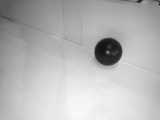

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_34 (Rescaling)    (None, 120, 160, 1)       0         
                                                                 
 conv2d_95 (Conv2D)          (None, 120, 160, 8)       208       
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 15, 20, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_96 (Conv2D)          (None, 15, 20, 16)        1168      
                                                                 
 dropout_30 (Dropout)        (None, 15, 20, 16)        0         
                                                                 
 flatten_34 (Flatten)        (None, 4800)              0         
                                                     

In [87]:
# Load images
images = []
targets = []

print(f"Loading images and targets from {UPSAMPLED_IMAGES_PATH}")

for filename in os.listdir(UPSAMPLED_IMAGES_PATH):
  images.append(cv2.imread(UPSAMPLED_IMAGES_PATH + "/" + filename, cv2.IMREAD_GRAYSCALE))
  targets.append(cv2.imread(UPSAMPLED_TARGETS_PATH + "/" + filename, cv2.IMREAD_COLOR)[:,:,0:2].astype(np.float32) / 255.0)

cv2_imshow(images[600])
cv2_imshow(np.pad(targets[600], ((0, 0), (0, 0), (0, 1))) * 255.0)

images = np.array(images)
targets = np.array(targets)

batch_size = 16

# WORKING MODEL
"""
model = Sequential([
  layers.Rescaling(1./255, input_shape=(input_height, input_width, 1)),
  layers.Conv2D(8, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(2),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(4),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(2),
  layers.Dropout(0.3),
  layers.Flatten(),
  #layers.Dense(1024, activation='linear'),
  layers.Dense(Ys * Xs * Cs, activation='linear'),
  layers.Reshape((Ys, Xs, Cs))
])
"""

# NEW MODEL
model = Sequential([
    layers.Rescaling(1./255, input_shape=(input_height, input_width, 1)),
    layers.Conv2D(8, 5, padding='same', activation='relu'),
    layers.MaxPooling2D(8),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.Dense(Ys * Xs * Cs, activation='linear'),
    layers.Reshape((Ys, Xs, Cs))
])

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

model.summary()

model.fit(images, targets, batch_size=batch_size, epochs=30, verbose=1)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open(MODEL_OUTPUT_PATH, 'wb') as f:
  f.write(tflite_model)

# Test

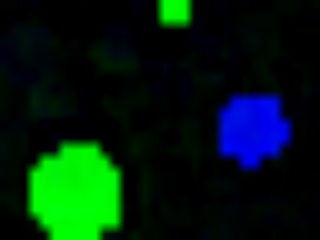

---------------------


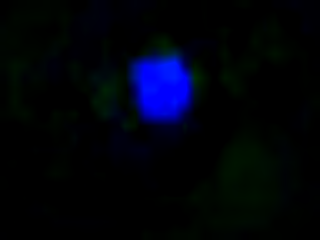

---------------------


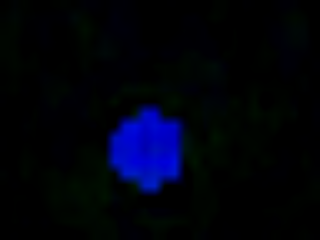

---------------------


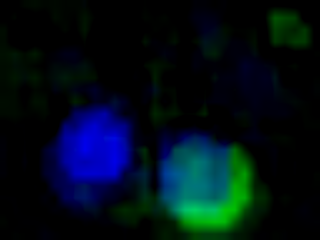

---------------------


In [88]:
test_images = []
for img in os.listdir(TEST_IMAGES_PATH):
  image = cv2.imread(TEST_IMAGES_PATH + "/" + img, cv2.IMREAD_GRAYSCALE).astype(np.float32)
  image = np.expand_dims(image, axis=0)
  image = np.expand_dims(image, axis=3)
  test_images.append(image)

interpreter = tf.lite.Interpreter(model_path=MODEL_OUTPUT_PATH)
interpreter.allocate_tensors()

output = interpreter.get_output_details()[0]
input = interpreter.get_input_details()[0]

for image in test_images:
  interpreter.set_tensor(input['index'], image)
  interpreter.invoke()
  out = interpreter.get_tensor(output['index'])
  cv2_imshow(cv2.resize(np.pad(out[0,:,:,:], ((0, 0), (0, 0), (0, 1))) * 255.0, (320, 240)))
  print("---------------------")